In [1]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import MultinomialNB

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [2]:
# reading data
df = pd.read_csv('train.csv')
df.head(1)

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz


In [3]:
df.shape

(37500, 19)

In [4]:
df.columns

Index(['index', 'beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name',
       'beer/style', 'review/appearance', 'review/aroma', 'review/overall',
       'review/palate', 'review/taste', 'review/text', 'review/timeStruct',
       'review/timeUnix', 'user/ageInSeconds', 'user/birthdayRaw',
       'user/birthdayUnix', 'user/gender', 'user/profileName'],
      dtype='object')

In [5]:
# checking null values
df.isnull().sum()

index                    0
beer/ABV                 0
beer/beerId              0
beer/brewerId            0
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/overall           0
review/palate            0
review/taste             0
review/text             10
review/timeStruct        0
review/timeUnix          0
user/ageInSeconds    29644
user/birthdayRaw     29644
user/birthdayUnix    29644
user/gender          22186
user/profileName         5
dtype: int64

In [6]:
# making copy of original dataset
df_copy = df.copy()

In [7]:
# filling in missing values for 'review/text'
df['review/text'].fillna(value='Missing', inplace=True)

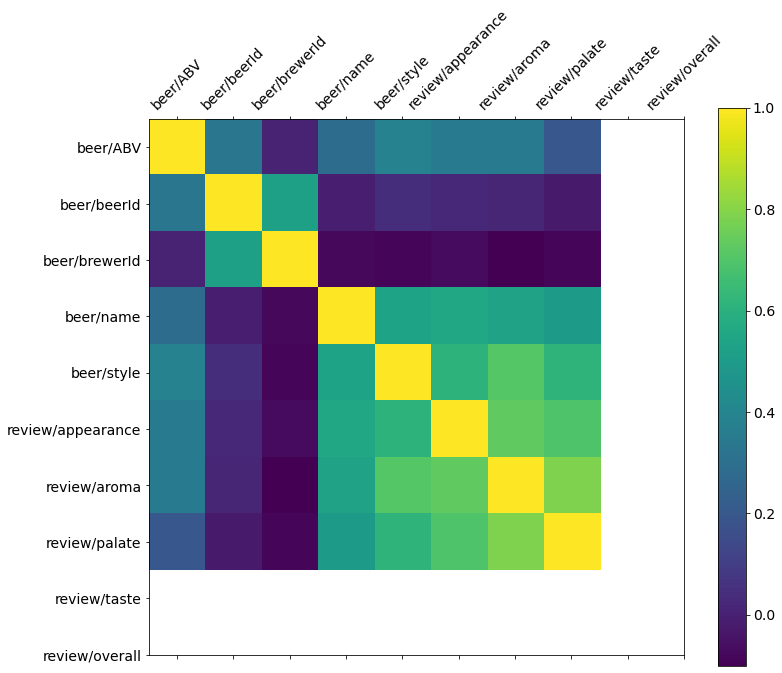

In [8]:
# gathering features to check correlation
corr_df = df_copy.filter(['beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name','beer/style', 
             'review/appearance', 'review/aroma','review/palate', 'review/taste','review/overall'])

# plotting correlation matrix
f = plt.figure(figsize=(12, 10))
plt.matshow(corr_df.corr(), fignum=f.number)
plt.xticks(range(corr_df.shape[1]), corr_df.columns, fontsize=14, rotation=45)
plt.yticks(range(corr_df.shape[1]), corr_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

(array([1.0000e+00, 0.0000e+00, 1.7600e+02, 2.4800e+02, 8.0700e+02,
        1.1930e+03, 3.3190e+03, 6.5510e+03, 1.3868e+04, 1.1337e+04]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

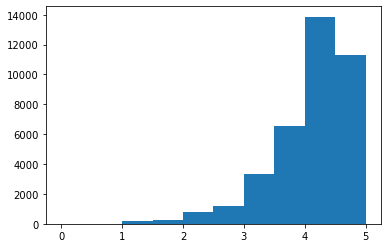

In [9]:
# checking the distribution of dependent variable
plt.hist(df['review/overall'],bins=10)

In [10]:
# implementing label encoder for categorical variable
lb_make = LabelEncoder()
df['beer/name'] = lb_make.fit_transform(df['beer/name'])
df['beer/style'] = lb_make.fit_transform(df['beer/style'])

In [11]:
# filtering columns having high correlation while omitting dependent variable
norm_df = df.filter(['beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name','beer/style', 
             'review/appearance', 'review/aroma','review/palate', 'review/taste'])
norm_df.head()

,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/palate,review/taste
0,5.0,46634,14338,368,61,4.0,4.0,4.0,4.0
1,11.0,3003,395,153,4,4.0,3.5,3.5,3.0
2,4.7,961,365,1044,14,3.5,4.0,3.5,3.5
3,4.4,429,1,1174,35,3.0,3.0,3.0,3.0
4,4.4,4904,1417,230,46,4.0,3.0,3.5,2.5


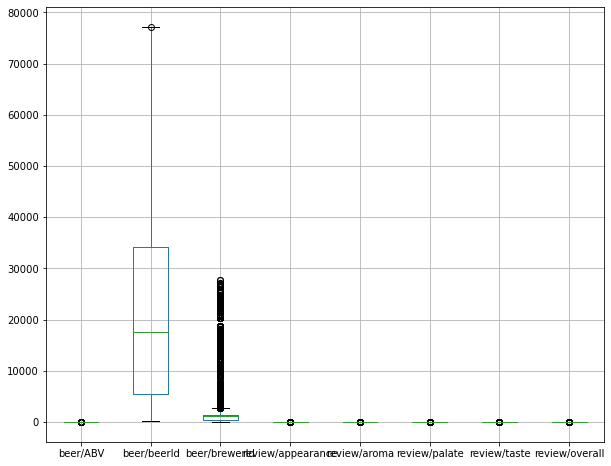

In [12]:
# checking for outliers
boxplot = df.boxplot(column=['beer/ABV', 'beer/beerId', 'beer/brewerId', 
             'review/appearance', 'review/aroma','review/palate', 'review/taste','review/overall'],figsize=(10,8))

In [13]:
# Normalizing using MinMax Scaler
x = norm_df.values
min_max_scale = MinMaxScaler()
x_scaled = min_max_scale.fit_transform(x)
scaled_df = pd.DataFrame(x_scaled)
scaled_df.head()

,0,1,2,3,4,5,6,7,8
0,0.085069,0.603113,0.515794,0.218139,0.648936,0.8,0.750,0.750,0.750
1,0.189236,0.036712,0.014175,0.090694,0.042553,0.8,0.625,0.625,0.500
2,0.079861,0.010204,0.013095,0.618850,0.148936,0.7,0.750,0.625,0.625
3,0.074653,0.003297,0.000000,0.695910,0.372340,0.6,0.500,0.500,0.500
4,0.074653,0.061390,0.050943,0.136337,0.489362,0.8,0.500,0.625,0.375


In [14]:
# Splitting dataset
X = scaled_df
# taking the natural logarithm of one plus the dependent variable
y = np.log1p(df['review/overall'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [15]:
# function to fit models and calculate error
def run_regression_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    print(model)
    print("Training set r score: ", model.score(X_train, y_train))
    print("Test set r score: ", model.score(X_test, y_test))
    predictions = model.predict(X_test)
    print("Mean Absolute Error on Test Set:", mean_absolute_error(y_test, predictions))
    print("Mean Squared Error on Test Set:", mean_squared_error(y_test, predictions))
    print("Root Mean Squared Error on Test Set:",np.sqrt(mean_squared_error(y_test,predictions)))
    plt.scatter(y_test, predictions)
    plt.ylabel('Predicted Score')
    plt.xlabel('Actual Score')
    plt.plot([0, 5], [0, 5])
    plt.show()
    plt.clf()

In [16]:
# defining some models
lr = LinearRegression()
rndfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=18)
xgbr = XGBRegressor(max_depth=18, n_estimators=100)
models = [lr, rndfr, xgbr]

LinearRegression()
Training set r score:  0.6683137998974384
Test set r score:  0.6757785662977711
Mean Absolute Error on Test Set: 0.06714329157491924
Mean Squared Error on Test Set: 0.008839330824183719
Root Mean Squared Error on Test Set: 0.094017715480561


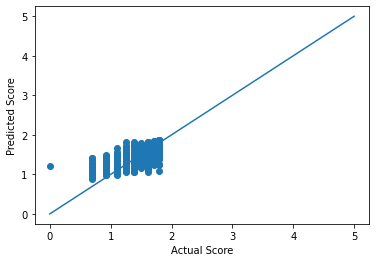

RandomForestRegressor(max_depth=18, n_jobs=-1)
Training set r score:  0.8670948896282855
Test set r score:  0.6707470769703086
Mean Absolute Error on Test Set: 0.0683658487862098
Mean Squared Error on Test Set: 0.008976505588343937
Root Mean Squared Error on Test Set: 0.0947444224656203


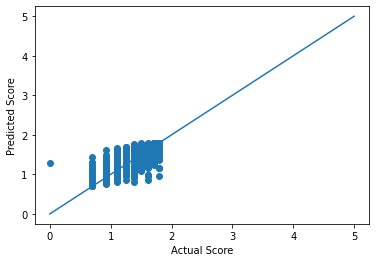

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=18,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Training set r score:  0.9089999297634213
Test set r score:  0.6102081542245033
Mean Absolute Error on Test Set: 0.07377022596886579
Mean Squared Error on Test Set: 0.010626993527341026
Root Mean Squared Error on Test Set: 0.1030873102148903


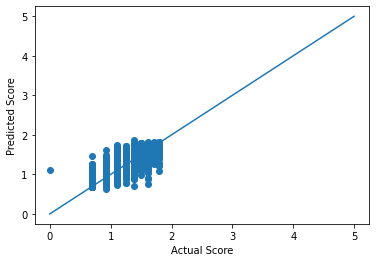

<Figure size 432x288 with 0 Axes>

In [17]:
# passing models to function
for model in models:
    run_regression_model(X_train, X_test, y_train, y_test, model)

<font size="5">Using review/text to try and improve accuracy</font>

In [18]:
# creating a corpus of all text
corpus = df['review/text']

In [19]:
# genetate term frequency–inverse document frequency matrix
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()

df_corp = pd.DataFrame(dense, columns=feature_names)

In [20]:
# concatinating tf-idf matrix with previous scaled data
complete_df = pd.concat([df_corp, scaled_df], axis=1, sort=False)

In [36]:
complete_df.shape

(37500, 41449)

In [21]:
# Splitting dataset
X = complete_df
y = np.log1p(df_copy['review/overall'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

RandomForestRegressor(max_depth=18, n_jobs=-1)
Training set r score:  0.8729489545286745
Test set r score:  0.7029281037534996
Mean Absolute Error on Test Set: 0.06489524262388892
Mean Squared Error on Test Set: 0.008099146128328119
Root Mean Squared Error on Test Set: 0.08999525614346636


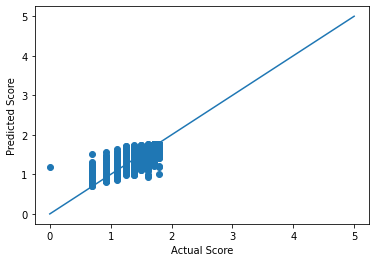

SGDRegressor(max_iter=40, random_state=101)
Training set r score:  0.6513509018791164
Test set r score:  0.6551976227328273
Mean Absolute Error on Test Set: 0.06932380819433658
Mean Squared Error on Test Set: 0.009400434285997022
Root Mean Squared Error on Test Set: 0.09695583678148016


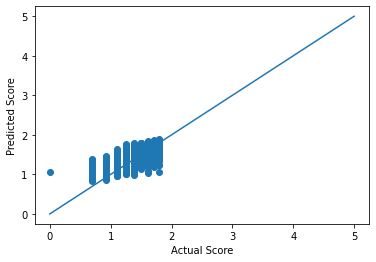

<Figure size 432x288 with 0 Axes>

In [22]:
# training two models on complete dataset
sgdr = SGDRegressor(loss='squared_loss', penalty='l2', random_state=101, max_iter=40)
rndfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=18)


models = [rndfr, sgdr]

for model in models:
    run_regression_model(X_train, X_test, y_train, y_test, model)

<font size="5">Random Forest Regressor gave the best RMSE score of 0.08999525614346636</font>